#**Sentiment Analysis on IMDB Reviews: VADER, Lexical Scoring, Logistic Regression, and Neural Networks**

#About Dataset:
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data

http://ai.stanford.edu/~amaas/data/sentiment/

- IMDB dataset having 50K movie reviews for natural language processing or Text analytics.

- This is a dataset for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training and 25,000 for testing.

##Steps:

1- Download and Extract Dataset: Retrieve the IMDB movie reviews dataset and extract its contents for analysis.

2- Preprocess Data: Normalize the text by converting it to lowercase, removing HTML tags, punctuation, and stopwords to prepare the reviews for analysis.

3- Sentiment Analysis with VADER: Utilize the VADER sentiment analysis tool to compute compound sentiment scores for each review.

4- Categorize Sentiments: Classify the reviews into five sentiment categories: very negative, negative, neutral, positive, and very positive, based on the VADER compound scores.

5- Enhance Scores for Extreme Words: Apply additional scoring adjustments for reviews containing extreme positive or negative words to reflect their intensity.

6- Train/Test Split: Divide the dataset into training and test sets to facilitate model evaluation.

7- Model Evaluation: Assess the performance of the classification models by calculating accuracy and visualizing results through a confusion matrix.

#Download, Extract and Load the Dataset
---

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'mahsaziaie'
os.environ['KAGGLE_KEY'] = 'kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

import zipfile
with zipfile.ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('imdb-dataset-of-50k-movie-reviews')

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 58% 15.0M/25.7M [00:00<00:00, 151MB/s]
100% 25.7M/25.7M [00:00<00:00, 195MB/s]


#Import Necessary Libraries
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
df = pd.read_csv('imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
df.shape

(50000, 2)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


#Preprocess the Data
---


In [ ]:
def preprocess_review(review):
    review = review.lower()
    review = review.replace('<br />', ' ')
    review = review.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(review)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].apply(preprocess_review)
df_unique = df.drop_duplicates(subset=['review']).copy()

In [ ]:
df_unique.head(10)

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
5,probably alltime favorite movie story selfless...,positive
6,sure would like see resurrection dated seahunt...,positive
7,show amazing fresh innovative idea 70s first a...,negative
8,encouraged positive comments film looking forw...,negative
9,like original gut wrenching laughter like movi...,positive


#Sentiment Analysis using VADER
---




In [ ]:
sid = SentimentIntensityAnalyzer()

#Thresholding for 5 Classes with Additional Scoring for Extreme Words
---

In [ ]:
def classify_sentiment(score):
    if score <= -0.8:
        return 'very negative'
    elif -0.8 < score <= -0.3:
        return 'negative'
    elif -0.3 < score < 0.3:
        return 'neutral'
    elif 0.3 <= score < 0.8:
        return 'positive'
    else:
        return 'very positive'

def enhance_score(review, score):
    words = set(review.split())
    if words & extreme_positive_words:
        score += 0.2
    if words & extreme_negative_words:
        score -= 0.2
    score = max(-1, min(1, score))
    return score

extreme_positive_words = {'excellent', 'amazing', 'incredible', 'fantastic', 'outstanding'}
extreme_negative_words = {'awful', 'terrible', 'horrible', 'worst', 'dreadful'}

df_unique['scores'] = df_unique['review'].apply(lambda review: sid.polarity_scores(review))
df_unique['compound'] = df_unique['scores'].apply(lambda score_dict: score_dict['compound'])

df_unique['enhanced_compound'] = df_unique.apply(lambda row: enhance_score(row['review'], row['compound']), axis=1)

df_unique['enhanced_sentiment_class'] = df_unique['enhanced_compound'].apply(lambda c: classify_sentiment(c))

In [ ]:
print(df_unique[['review', 'enhanced_compound', 'enhanced_sentiment_class']].head(20))

                                               review  enhanced_compound  \
0   one reviewers mentioned watching 1 oz episode ...            -0.9934   
1   wonderful little production filming technique ...             0.9582   
2   thought wonderful way spend time hot summer we...             0.9692   
3   basically theres family little boy jake thinks...            -0.8858   
4   petter matteis love time money visually stunni...             0.9887   
5   probably alltime favorite movie story selfless...             0.9584   
6   sure would like see resurrection dated seahunt...             0.9246   
7   show amazing fresh innovative idea 70s first a...             0.9649   
8   encouraged positive comments film looking forw...            -0.8806   
9   like original gut wrenching laughter like movi...             0.9432   
10  phil alien one quirky films humour based aroun...             0.9295   
11  saw movie 12 came recall scariest scene big bi...            -0.2467   
12  im big f

In [ ]:
print(f"Shape of train_df: {df_unique.shape}")

Shape of train_df: (49575, 6)


In [ ]:
class_counts = df_unique['enhanced_sentiment_class'].value_counts()
print("Number of samples in each sentiment class:")
print(class_counts)

Number of samples in each sentiment class:
enhanced_sentiment_class
very positive    24239
very negative     9439
positive          7669
negative          4578
neutral           3650
Name: count, dtype: int64


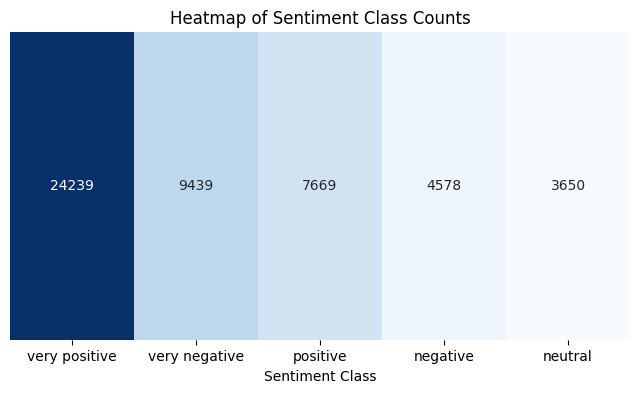

In [ ]:
class_counts_df = pd.DataFrame(class_counts).reset_index()
class_counts_df.columns = ['Sentiment Class', 'Count']

heatmap_data = pd.DataFrame(class_counts_df['Count']).T
heatmap_data.index = ['Sentiment Counts']

plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_counts_df['Sentiment Class'], yticklabels=False)
plt.xlabel('Sentiment Class')
plt.title('Heatmap of Sentiment Class Counts')
plt.show()

#Train/Test Split
---


In [ ]:
X = df_unique['review']
y = df_unique['enhanced_sentiment_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
train_df = pd.DataFrame({'review': X_train, 'enhanced_sentiment_class': y_train})
test_df = pd.DataFrame({'review': X_test, 'enhanced_sentiment_class': y_test})

In [ ]:
print(f"Shape of train_df: {train_df.shape}")

Shape of train_df: (39660, 2)


In [ ]:
train_class_counts = train_df['enhanced_sentiment_class'].value_counts()
print("Number of samples in each sentiment class (Train):")
print(train_class_counts)

Number of samples in each sentiment class (Train):
enhanced_sentiment_class
very positive    19391
very negative     7551
positive          6135
negative          3663
neutral           2920
Name: count, dtype: int64


In [ ]:
print(f"Shape of test_df: {test_df.shape}")

Shape of test_df: (9915, 2)


In [ ]:
test_class_counts = test_df['enhanced_sentiment_class'].value_counts()
print("\nNumber of samples in each sentiment class (Test):")
print(test_class_counts)


Number of samples in each sentiment class (Test):
enhanced_sentiment_class
very positive    4848
very negative    1888
positive         1534
negative          915
neutral           730
Name: count, dtype: int64


#**Models**
---

Logistic Regression


Accuracy: 0.6711

Classification Report:
               precision    recall  f1-score   support

     negative       0.35      0.05      0.09       915
      neutral       0.26      0.01      0.02       730
     positive       0.43      0.19      0.27      1534
very negative       0.65      0.84      0.73      1888
very positive       0.71      0.97      0.82      4848

     accuracy                           0.67      9915
    macro avg       0.48      0.41      0.39      9915
 weighted avg       0.59      0.67      0.59      9915



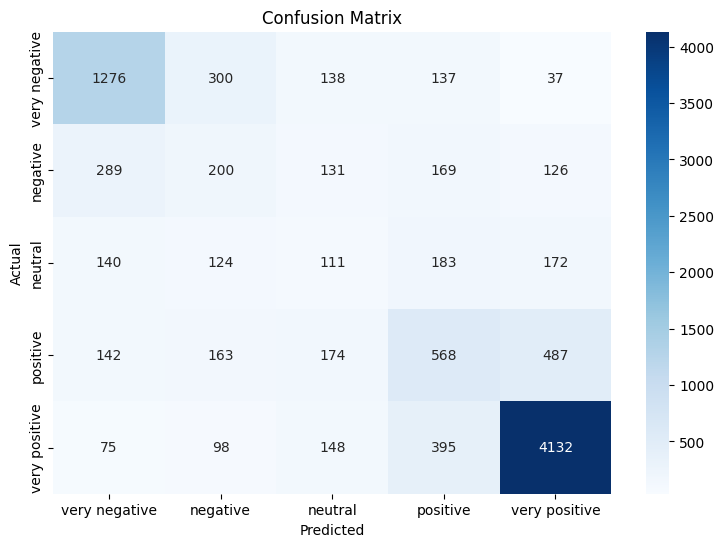


Execution time: 65.48 seconds
Execution time: 1.09 minutes


In [ ]:
start_time = time.time()

X_train_text = train_df['review']
y_train = train_df['enhanced_sentiment_class']
X_test_text = test_df['review']
y_test = test_df['enhanced_sentiment_class']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

pipeline = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(max_iter=1000)
)

pipeline.fit(X_train_text, y_train_encoded)

y_pred_encoded = pipeline.predict(X_test_text)

y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test_encoded)

accuracy = accuracy_score(y_test_original, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_original, y_pred))

plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['very negative', 'negative', 'neutral', 'positive', 'very positive'], yticklabels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

end_time = time.time()
execution_time_seconds = end_time - start_time
execution_time_minutes = execution_time_seconds / 60
print("\nExecution time: {:.2f} seconds".format(execution_time_seconds))
print("Execution time: {:.2f} minutes".format(execution_time_minutes))

Feedforward Neural Network


Accuracy: 0.6341

Classification Report:
               precision    recall  f1-score   support

very negative       0.23      0.22      0.22       915
     negative       0.16      0.15      0.16       730
      neutral       0.39      0.37      0.38      1534
     positive       0.66      0.68      0.67      1888
very positive       0.83      0.85      0.84      4848

     accuracy                           0.63      9915
    macro avg       0.45      0.45      0.45      9915
 weighted avg       0.63      0.63      0.63      9915



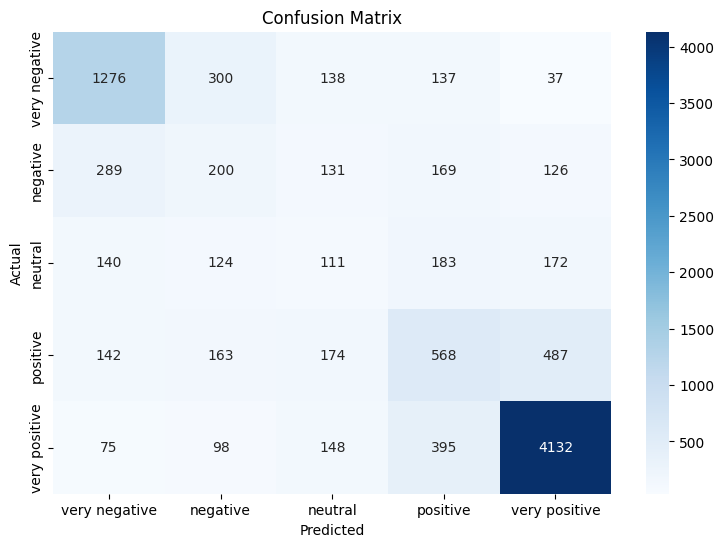


Execution time: 140.92 seconds
Execution time: 2.35 minutes


In [ ]:
from sklearn.neural_network import MLPClassifier
import time
start_time = time.time()

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 1))),
    ('clf', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, solver='adam', random_state=42))
])

pipeline.fit(train_df['review'], train_df['enhanced_sentiment_class'])

predictions = pipeline.predict(test_df['review'])

accuracy = accuracy_score(test_df['enhanced_sentiment_class'], predictions)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(test_df['enhanced_sentiment_class'], predictions, target_names=['very negative', 'negative', 'neutral', 'positive', 'very positive']))

conf_matrix = confusion_matrix(test_df['enhanced_sentiment_class'], predictions, labels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])

plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['very negative', 'negative', 'neutral', 'positive', 'very positive'], yticklabels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

end_time = time.time()
execution_time_seconds = end_time - start_time
execution_time_minutes = execution_time_seconds / 60
print("\nExecution time: {:.2f} seconds".format(execution_time_seconds))
print("Execution time: {:.2f} minutes".format(execution_time_minutes))